In [1]:
import random
import glob
import os
import shutil
import torch
import pandas as pd
from PIL import Image
from torchvision import models, transforms, datasets
import torch.nn as nn
import torch.optim as optim
import pyper
import numpy as np
import copy
import matplotlib.pyplot as plt
import json
import sklearn
import sklearn.svm
from sklearn.externals import joblib
import scipy
from scipy.optimize import differential_evolution
from scipy.stats import gaussian_kde
import importlib


random.seed(0)
np.random.seed(0)

/root/anaconda3/envs/au/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/root/anaconda3/envs/au/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

# Define functions

In [2]:
def init_dir(dn):
    if os.path.exists(dn):
        shutil.rmtree(dn)
    os.makedirs(dn)

    
def init_and_copy_dir( src_path, dst_path ):
    if os.path.exists(dst_path):
        shutil.rmtree(dst_path)
        
    shutil.copytree(src_path, dst_path) 
    
def ICC(label_lst,pred_lst):
    
    data = []
    for i in range(len(label_lst)):
        data.append([label_lst[i],pred_lst[i]])
    
    data = np.array(data)
    
    r_env = pyper.R(use_numpy=True)
    r_env("library(irr)")
    r_env.assign("data",data)
    r_env("value <- icc(data,model='twoway')$value")
    value = r_env.get("value")
    
    if np.isnan(value):
        value = -1000
    
    return value

def MAE(label_lst,pred_lst):
    
    if len(label_lst) == 0:
        return np.nan    
    
    total = 0
    
    for i in range(len(label_lst)):
        total += abs(label_lst[i] - pred_lst[i])

    return total/len(label_lst)

def RMSE(label_lst,pred_lst):
    
    if len(label_lst) == 0:
        return np.nan
    
    total = 0
    
    for i in range(len(label_lst)):
        total += (label_lst[i] - pred_lst[i])**2

    return (total/len(label_lst))**0.5

def measure_map( label_lst,pred_lst ):
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    
    for i in range(len(label_lst)):

        if label_lst[i] == 1:     
            if pred_lst[i] == 1:
                TP += 1
            elif pred_lst[i] == 0:
                FN += 1
            else:
                raise
        elif label_lst[i] == 0:         
            if pred_lst[i] == 1:
                FP += 1
            elif pred_lst[i] == 0:
                TN += 1
            else:
                raise
        else:
            raise                
                
                
    return TP,FP,FN,TN


def PRECISION( TP,FP,FN,TN ):    
    
    if TP + FP == 0:
        return 0.0   

    return TP / ( TP + FP )


def RECALL( TP,FP,FN,TN ):

    if TP + FN == 0:
        return 0.0  
    
    return TP / ( TP + FN )

def ACCURACY( TP,FP,FN,TN ):

    if TP + FP + TN + FN == 0:
        return 0.0
    
    return (TP+TN) / ( TP + FP + TN + FN )

def F1( TP,FP,FN,TN ):
    
    recall = RECALL( TP,FP,FN,TN )
    precision = PRECISION( TP,FP,FN,TN )
    
    if recall + precision == 0:
        return 0.0

    return 2 * recall * precision / ( recall + precision )


def get_label_name( intensity, int_occ_mode ):
    
    if int_occ_mode == "int":
        return "INT%d" % intensity
    elif int_occ_mode == "occ":
        if intensity == 0:
            return "NOOCC"
        elif intensity == 1:
            return "OCC"
        else:
            raise
    else:
        raise

def get_measurement_score( label_lst, pred_lst, int_occ_mode ):
    
    if int_occ_mode == "int":
        return ICC( label_lst, pred_lst )
    else:
        TP,FP,FN,TN = measure_map( label_lst,pred_lst )
        return F1( TP,FP,FN,TN )        


In [3]:
def load_img( img_name_0 ):
    with open(img_name_0, 'rb') as f:
        img_0 = Image.open(f)
        img_0 = img_0.convert('RGB')

    img_0 = transforms.ToTensor()(img_0)
    img_0 = transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(img_0)
    
    return img_0

def get_best_epoch( filename, category, direct, param ):

    fp = open(filename,"r")
    epoch_score_lst = json.load( fp )
    fp.close()
    
    if "Valid" in param.phase_lst:

        pose_lst = list(param.dataset_path_lst["Valid"].keys())
        best_epoch = 0
        for epoch in range(len(epoch_score_lst["Valid"][pose_lst[0]][category])):

            score_cur_best = np.average([epoch_score_lst["Valid"][pose][category][best_epoch] for pose in pose_lst])
            score = np.average([epoch_score_lst["Valid"][pose][category][epoch] for pose in pose_lst])

            if direct == "UPPER":
                if score_cur_best < score:
                    best_epoch = epoch
            elif direct == "LOWER":
                if score_cur_best > score:
                    best_epoch = epoch
    
    else:
        
        pose_lst = list(param.dataset_path_lst["Train"].keys())
        best_epoch = len(epoch_score_lst["Train"][pose_lst[0]][category])-1
                
                
                
    print("best_epoch",best_epoch)
      
    print("---")
    
    for phase in epoch_score_lst.keys():
        pose_lst = list(param.dataset_path_lst[phase].keys())
        for c in epoch_score_lst[phase][pose_lst[0]].keys():
            
            score_lst = [epoch_score_lst[phase][pose][c][best_epoch] for pose in pose_lst]
            print(phase,c,"AVERAGE:",np.average(score_lst),"STD:",np.std(score_lst))
            
    return best_epoch
    
def show_score_lst( filename, dataset_path_lst ):

    fp = open(filename,"r")
    epoch_score_lst = json.load( fp )
    fp.close()
    
    pose_lst = list(dataset_path_lst["Train"].keys())
    for c in epoch_score_lst["Train"][pose_lst[0]].keys():
        for phase in epoch_score_lst.keys():
            pose_lst = list(dataset_path_lst[phase].keys())
            en = len(epoch_score_lst[phase][pose_lst[0]][c])
            score_lst = [ np.average([ epoch_score_lst[phase][pose][c][epoch] for pose in pose_lst ]) for epoch in range(en) ]
            
            plt.plot(list(range(len(score_lst))),score_lst,label="%s %s" % (phase,c))

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.title(c)
        plt.show()

In [4]:
def get_pairwise_net_best_epoch( param ):

    filename = "./log/pair_net_epoch_score_lst_%s_%s.json" % (param.au_name,"posesall")

    pair_net_best_epoch = get_best_epoch( filename, "LOSS", "LOWER", param )
    show_score_lst( filename, param.dataset_path_lst )

    return pair_net_best_epoch

In [5]:
def load_param():
    
    import param    
    importlib.reload(param)
    
    param.device = torch.device(param.map_location)

    return param

In [6]:
def extract_enable_img_filename_lst( input_filename_lst, enable_subject_lst ):
    
    output_filename_lst = []
    
    for input_filename in input_filename_lst:
        subject = os.path.basename(input_filename).split("_")[2]
        
        if subject in enable_subject_lst:
            output_filename_lst.append(input_filename)
            
    return output_filename_lst

def get_img_filename_lst( dataset_name, dataset_path, au_name, intensity, phase, param ):
    
    dataset_path_dir = os.path.basename(os.path.dirname(dataset_path))

    if dataset_path_dir.find( "frames_for_pytorch_procrustes_occ" ) == 0:

        occ_int_flag = "occ"

        if intensity > 1:
            filename_lst = []
        else:
            dirname = dataset_path + "/" + au_name + "/" + get_label_name( intensity, "occ" )
            filename_lst = glob.glob(dirname + "/*.jpg")

    elif dataset_path_dir.find( "frames_for_pytorch_procrustes_int" ) == 0:

        occ_int_flag = "int"
        
        dirname = dataset_path + "/" + au_name + "/" + get_label_name( intensity, "int" )
        filename_lst = glob.glob(dirname + "/*.jpg")

    elif dataset_path_dir.find( "labels_for_pytorch_procrustes_occ" ) == 0:

        occ_int_flag = "occ"

        if intensity > 1:
            filename_lst = []
        else:
            filename_lst = []
            dirname = dataset_path + "/" + au_name
            for csv_filename in glob.glob(dirname+"/*.csv"):

                csv_basename = "_".join(os.path.basename(csv_filename).split("_")[:5])

                for line in open(csv_filename):

                    frame_id, intensity_tmp = line.rstrip().split(",")
                    intensity_tmp = int(intensity_tmp)

                    if param.enable_pair_dataset_equal_test and phase == "Test":
                        if not 0 <= intensity_tmp <= 5:
                            intensity_tmp = 0


                    if intensity_tmp != intensity:
                        continue

                    img_filename = param.imgs_top_dirname_lst[dataset_name] + "/" + csv_basename + "_" + frame_id + ".jpg"

                    if not os.path.exists(img_filename):
                        continue                            

                    filename_lst.append(img_filename)
                    
    elif dataset_path_dir.find( "labels_for_pytorch_procrustes_int" ) == 0:

        occ_int_flag = "int"

        filename_lst = []
        dirname = dataset_path + "/" + au_name
        for csv_filename in glob.glob(dirname+"/*.csv"):

            csv_basename = "_".join(os.path.basename(csv_filename).split("_")[:5])

            for line in open(csv_filename):

                frame_id, intensity_tmp = line.rstrip().split(",")
                intensity_tmp = int(intensity_tmp)

                if param.enable_pair_dataset_equal_test and phase == "Test":
                    if not 0 <= intensity_tmp <= 5:
                        intensity_tmp = 0

                if intensity_tmp != intensity:
                    continue

                img_filename = param.imgs_top_dirname_lst[dataset_name] + "/" + csv_basename + "_" + frame_id + ".jpg"
                
                if not os.path.exists(img_filename):
                    continue                            

                filename_lst.append(img_filename)

    else:
        raise 
        
    return filename_lst, occ_int_flag

def get_filename_lst_cache(dataset_path_lst,enable_subject_lst,phase,param):

    au_name = param.au_name
    pair_net_divide_task = param.pair_net_divide_task
    
    filename_lst_cache_all = []
    for dataset_name,dataset_path_ll in dataset_path_lst.items():
        filename_lst_cache = {}
        occ_int_flag = "int"
        pose_mode = "single_pose"
        pose_prev = None
        
        for intensity in range(6):
            filename_lst_cache[intensity] = {}
            
            for dataset_path in dataset_path_ll:    


                filename_lst, occ_int_flag = get_img_filename_lst( dataset_name, dataset_path, au_name, intensity, phase, param )                

                for filename in sorted(extract_enable_img_filename_lst(filename_lst,enable_subject_lst[dataset_name])):
                    
                    if pair_net_divide_task:
                        subject = os.path.basename(filename).split("_")[2] + "_" + os.path.basename(filename).split("_")[3]
                    else:
                        subject = os.path.basename(filename).split("_")[2]
                    
                    pose = int(os.path.basename(filename).split("_")[4])
                    frame_id = int(os.path.splitext(os.path.basename(filename))[0].split("_")[5][len("frame"):])

                    if (not pose_prev is None) and (pose != pose_prev):
                        pose_mode = "multi_pose"
                    pose_prev = pose

                    if not subject in filename_lst_cache[intensity]:
                        filename_lst_cache[intensity][subject] = [[],[],[]]

                    filename_lst_cache[intensity][subject][0].append(filename)
                    filename_lst_cache[intensity][subject][1].append(pose)
                    filename_lst_cache[intensity][subject][2].append(frame_id)
                
        filename_lst_cache_all.append((filename_lst_cache,occ_int_flag,pose_mode,dataset_name))
        
    return filename_lst_cache_all

In [7]:
def make_dataset_for_pair_net( param ):
 
    for phase in param.phase_lst:
        for pose in param.dataset_path_lst[phase].keys():

            csv_filename = param.dataset_lst_dirname + "/AU_INT_PAIR_%s_%s_%s.csv" % (param.au_name,phase,pose)

            print("---------------------")

            print(csv_filename)

            filename_lst_cache_all = get_filename_lst_cache(param.dataset_path_lst[phase][pose],param.enable_subject_lst[phase][pose],phase,param)

            for i in range(len(filename_lst_cache_all)):
                print("filename_lst_cache_all",filename_lst_cache_all[i][1],filename_lst_cache_all[i][2],filename_lst_cache_all[i][3])


            fp = open(csv_filename,"w")

            counter = 0
            while counter < param.dataset_num_lst[phase]:

                dataset_id = random.sample(list(range(len(filename_lst_cache_all))),1)[0]
                filename_lst_cache,occ_int_flag,pose_mode,_ = filename_lst_cache_all[dataset_id]

                intensity_pair_lst = []
                for intensity_0 in range(2 if occ_int_flag == "occ" else 6):
                    for intensity_1 in range(2 if occ_int_flag == "occ" else 6):

                        if param.enable_pair_dataset_equal_test and phase == "Test":
                            pass

                        else:                        
                            if abs(intensity_0 - intensity_1) == 0:
                                continue


                        intensity_pair_lst.append((intensity_0,intensity_1))

                target_intensity_pair = random.sample(intensity_pair_lst,1)[0]               


                intensity_0 = target_intensity_pair[0]
                intensity_1 = target_intensity_pair[1]


                if intensity_0 < intensity_1:
                    label = 1
                elif intensity_0 > intensity_1:
                    label = 0
                else:
                    if param.enable_pair_dataset_equal_test and phase == "Test":
                        label = 0
                    else:
                        raise


                subject_lst_0 = sorted(list(filename_lst_cache[intensity_0].keys()))
                subject_lst_1 = sorted(list(filename_lst_cache[intensity_1].keys()))


                if len(subject_lst_0) == 0:
                    continue
                if len(subject_lst_1) == 0:
                    continue


                pair_lst = []
                
                if param.pair_net_dataset_only_same_subject:

                    for s0 in subject_lst_0:
                        for s1 in subject_lst_1:
                            if s0 == s1:
                                pair_lst.append((s0,s1))
                else:
                    
                    for s0 in subject_lst_0:
                        for s1 in subject_lst_1:
                            pair_lst.append((s0,s1))



                if len(pair_lst) == 0:
                    continue


                subject_0,subject_1 = random.sample(pair_lst,1)[0]


                filename_lst_0,pose_lst_0,frame_id_lst_0 = filename_lst_cache[intensity_0][subject_0]
                filename_lst_1,pose_lst_1,frame_id_lst_1 = filename_lst_cache[intensity_1][subject_1]


                if len(filename_lst_0) == 0:
                    continue
                if len(filename_lst_1) == 0:
                    continue

                filename_0 = random.sample(filename_lst_0,1)[0]
                filename_1 = random.sample(filename_lst_1,1)[0]

                fp.write("%s,%s,%d\n" % (os.path.abspath(filename_0),os.path.abspath(filename_1),label))
                counter += 1


            fp.close()   

In [8]:
def make_dataset_for_pair_net_prediction( param ):
  
    for phase in param.phase_lst:
        for pose in param.intensity_tune_dataset_path_lst[phase].keys():
            csv_filename = param.dataset_lst_dirname + "/AU_INT_TUNE_%s_%s_%s.csv" % (param.au_name,phase,pose)

            print(csv_filename)

            fp = open(csv_filename,"w")

            for dataset_name in param.intensity_tune_dataset_path_lst[phase][pose].keys():

                for cdirname in param.intensity_tune_dataset_path_lst[phase][pose][dataset_name]:
                    filename_lst = {}

                    for intensity in range(param.intensity_level):
                        
                        fl,_ = get_img_filename_lst( dataset_name, cdirname, param.au_name, intensity, phase, param )
                        
                        for filename in sorted(extract_enable_img_filename_lst(fl, param.enable_subject_lst[phase][pose][dataset_name])):

                            subject_task_pose = os.path.basename(filename).split("_")[2] + "_" + os.path.basename(filename).split("_")[3] + "_" + os.path.basename(filename).split("_")[4]
                            if not subject_task_pose in filename_lst:
                                filename_lst[subject_task_pose] = []
                            filename_lst[subject_task_pose].append((filename,intensity))


                    for subject_task_pose, filename_intensity_lst in filename_lst.items():

                        if param.intensity_tune_sampling_max <= 0:
                            sampling_num = len(filename_intensity_lst)
                        else:
                            sampling_num = min(param.intensity_tune_sampling_max,len(filename_intensity_lst))



                        for filename,intensity in random.sample(filename_intensity_lst,sampling_num):
                            fp.write("%s,%d\n" % (os.path.abspath(filename),intensity))
            fp.close()


In [9]:
def make_dataset( param ):
    make_dataset_for_pair_net( param )
    make_dataset_for_pair_net_prediction( param )

In [10]:

class PairDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file,header=None)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name_0 = self.df.iloc[idx,0]
        img_name_1 = self.df.iloc[idx,1]
        label = self.df.iloc[idx,2]
       
        img_0 = load_img( img_name_0 )
        img_1 = load_img( img_name_1 )

        return img_0,img_1,label,img_name_0,img_name_1
    
def get_dataloaders_for_pairwise_net( param ):

    dataloaders = {}

    for phase in param.phase_lst:
        dataloaders[phase] = {}
        for pose in param.dataset_path_lst[phase].keys():

            csv_filename = param.dataset_lst_dirname + "/AU_INT_PAIR_%s_%s_%s.csv" % (param.au_name,phase,pose)

            pair_dataset = PairDataset(csv_filename)
            dataloader = torch.utils.data.DataLoader(pair_dataset, batch_size=param.batch_size_bin, shuffle=True, num_workers=1)

            dataloaders[phase][pose] = dataloader
                
    return dataloaders

In [11]:
def torch_sigmoid(x,epsilon):
    return (1/(1+torch.exp(-x)))*(1-2*epsilon) + epsilon

def torch_logit(x):
    return torch.log(x/(1-x))


class PairNet(nn.Module):
    def __init__(self,param):
        super(PairNet, self).__init__()
        
        self.pair_net_conf_mode = param.pair_net_conf_mode
        
        classifier_dim = 1
        if self.pair_net_conf_mode == "integrated":
            classifier_dim += 1
        
        
        self.epsilon = 1.0e-3


        self.model = copy.deepcopy(models.vgg16(pretrained=True))
        for name, pm in self.model.named_parameters():
            if ('features.0.' in name or 'features.2.' in name):
                pm.requires_grad = False
        self.model.classifier[6] = nn.Linear(4096, classifier_dim)

        
        if self.pair_net_conf_mode == "separated":        
            self.model_conf = copy.deepcopy(models.vgg16(pretrained=True))
            for name, pm in self.model_conf.named_parameters():
                if ('features.0.' in name or 'features.2.' in name):
                    pm.requires_grad = False
            self.model_conf.classifier[6] = nn.Linear(4096, classifier_dim)
        
        
    def freeze_model( self ):
        for name, param in self.model.named_parameters():
            param.requires_grad = False            
        
        
    def forward(self, img_0, img_1):
        
        x_0,conf_0 = self.forward_single(img_0)
        x_1,conf_1 = self.forward_single(img_1)
        
        return x_0, x_1, conf_0, conf_1
    

    def forward_only_pseudo(self, img_0, img_1):
        x_0 = self.model.forward(img_0)
        x_1 = self.model.forward(img_1)
        conf_0 = None
        conf_1 = None
        
        return x_0, x_1, conf_0, conf_1

    def forward_single(self, img_0):
        
        if self.pair_net_conf_mode == "disabled":
            x_0 = self.model.forward(img_0)
            conf_0 = None
        
        elif self.pair_net_conf_mode == "integrated":        
            _x_0 = self.model.forward(img_0)
           
            x_0 = torch.unsqueeze(_x_0[:,0],1)
            conf_0 = torch.unsqueeze(_x_0[:,1],1)

            conf_0 = torch.clamp( conf_0, min=-10, max=10 )
            conf_0 = torch.exp(conf_0)

        elif self.pair_net_conf_mode == "separated":
            x_0 = self.model.forward(img_0)
            conf_0 = self.model_conf.forward(img_0)
            
            conf_0 = torch.clamp( conf_0, min=-10, max=10 )
            conf_0 = torch.exp(conf_0)
        else:
            raise
            
        return x_0, conf_0
            
    
def my_loss_func(x_0, x_1, conf_0, conf_1, label, conf_mode, param ):
    
    x_0 = torch.squeeze(x_0,1)
    x_1 = torch.squeeze(x_1,1)


    label = label*2-1
    
    
    
    if conf_mode:
        
        conf_0 = torch.squeeze(conf_0,1)
        conf_1 = torch.squeeze(conf_1,1)
        
        m = param.pair_net_loss_m_conf
        
        p = 1 - 0.5*(1+torch.erf( ( m - (x_1 - x_0) * label) / torch.sqrt( 2*(conf_0*conf_0 + conf_1*conf_1)) ) )
        p = torch.clamp(p,min=param.epsilon)    
        loss_element = -torch.log(p)
      
        
    else:
        m = param.pair_net_loss_m
        loss_element = torch.clamp(m - (x_1 - x_0)*label, min=0)   
    
    loss = torch.mean(loss_element)
    
    return loss

In [12]:
def train_pairwise_net( param, separate_conf_mode, pair_net_best_filename=None ):

    print("=====================")
    print("au_name",param.au_name)
    
    dataloaders = get_dataloaders_for_pairwise_net( param )

    pair_net = PairNet( param )
    if separate_conf_mode:
        pair_net.load_state_dict(torch.load(pair_net_best_filename))
        pair_net.freeze_model()    
    pair_net = pair_net.to(param.device)

    if param.pairwise_net_optimizer == "Adam":
        optimizer = optim.Adam(pair_net.parameters(), lr=0.00005)
    elif param.pairwise_net_optimizer == "AdamW":
        optimizer = optim.AdamW(pair_net.parameters(), lr=0.00005, weight_decay=10.0)
    else:
        raise


    epoch_score_lst = { phase: { pose: { category: [] for category in ["ACC","LOSS"] } for pose in param.dataset_path_lst[phase].keys() } for phase in param.phase_lst }


    for epoch in range(param.epoch_num):
        print("----------------")
        print("epoch:",epoch)
        for phase in param.phase_lst:
            print(" phase:",phase)
            
            if phase == "Train":
                if separate_conf_mode:
                    pair_net.model.eval()
                    pair_net.model_conf.train()
                else:
                    pair_net.train()
            else:
                if separate_conf_mode:
                    pair_net.model_conf.eval()
                else:
                    pair_net.eval()
                        
            for pose in param.dataset_path_lst[phase].keys():
            
                print("    pose:",pose)

                running_corrects = 0
                total_input_size = 0
                running_loss = 0
                pred_lst = []
                label_lst = []
                path_0_lst = []
                path_1_lst = []

                for img_0_batch, img_1_batch, label_batch, path_0_batch, path_1_batch in dataloaders[phase][pose]:


                    img_0_batch = img_0_batch.to(param.device)
                    img_1_batch = img_1_batch.to(param.device)
                    label_batch = label_batch.to(param.device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase=="Train"):

                        if separate_conf_mode:
                            x0_batch,x1_batch,conf0_batch,conf1_batch = pair_net.forward(img_0_batch,img_1_batch)
                        else:
                            if param.pair_net_conf_mode in ["disabled","integrated"]:
                                x0_batch,x1_batch,conf0_batch,conf1_batch = pair_net.forward(img_0_batch,img_1_batch)
                            elif param.pair_net_conf_mode == "separated":
                                x0_batch,x1_batch,conf0_batch,conf1_batch = pair_net.forward_only_pseudo(img_0_batch,img_1_batch)
                            else:
                                raise
                            
                        output_batch = torch.cat([x0_batch,x1_batch],dim=1)
                        _, pred_batch = torch.max(output_batch, 1)

                        if separate_conf_mode:
                            loss = my_loss_func(x0_batch,x1_batch,conf0_batch,conf1_batch, label_batch, True, param )
                        else:
                            if param.pair_net_conf_mode in ["disabled","separated"]: 
                                loss = my_loss_func(x0_batch,x1_batch,conf0_batch,conf1_batch, label_batch, False, param )
                            elif param.pair_net_conf_mode == "integrated":
                                loss = my_loss_func(x0_batch,x1_batch,conf0_batch,conf1_batch, label_batch, True, param )
                            else:
                                raise
                            
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                        running_loss += loss.item() * img_0_batch.size(0)
                        running_corrects += torch.sum(pred_batch == label_batch.data)
                        total_input_size += img_0_batch.size(0)

                    pred_lst += list(pred_batch.to('cpu').detach().numpy().copy())
                    label_lst += list(label_batch.to('cpu').detach().numpy().copy())
                    path_0_lst += list(path_0_batch)                       
                    path_1_lst += list(path_1_batch)

                   
                epoch_acc = float((running_corrects.double()  / total_input_size).to('cpu').detach().numpy().copy())
                epoch_loss = running_loss / total_input_size
                         

                print("          epoch_acc",epoch_acc)
                print("          epoch_loss",epoch_loss)

                epoch_score_lst[phase][pose]["ACC"].append(epoch_acc)
                epoch_score_lst[phase][pose]["LOSS"].append(epoch_loss)

                fp = open("./log/pair_net_epoch_score_lst_%s_%s.json" % (param.au_name, "posesall") ,"w")
                json.dump( epoch_score_lst, fp )
                fp.close()



                fp_pred_result = open("./pred_result/pair_net_%s_epoch_%d_phase_%s_%s.csv" % (param.au_name,epoch,phase,pose),"w")
                fp_pred_result.write("path_0,path_1,label,pred\n")
                for i in range(len(path_0_lst)):
                    fp_pred_result.write("%s,%s,%d,%d\n" % (path_0_lst[i],path_1_lst[i],int(label_lst[i]),int(pred_lst[i])) ) 
                fp_pred_result.close()


                if phase == "Train":
                    torch.save(pair_net.state_dict(), "./model/pair_net_%s_epoch_%d_%s.pt" % (param.au_name, epoch, "posesall" ) )


In [13]:
class IntensityTuneDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file,header=None)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name_0 = self.df.iloc[idx,0]
        label = self.df.iloc[idx,1]
       
        img_0 = load_img( img_name_0 )

        return img_0,label,img_name_0


def get_dataloaders_for_intensity_tune( param ):

    dataloaders_intensity_tune = {}
    for phase in param.phase_lst:
        dataloaders_intensity_tune[phase] = {}
        for pose in param.intensity_tune_dataset_path_lst[phase].keys():

            csv_filename = param.dataset_lst_dirname + "/AU_INT_TUNE_%s_%s_%s.csv" % ( param.au_name, phase, pose)

            intensity_tune_dataset = IntensityTuneDataset(csv_filename)
            dataloader = torch.utils.data.DataLoader(intensity_tune_dataset, batch_size=param.batch_size_int, shuffle=True, num_workers=1)

            dataloaders_intensity_tune[phase][pose] = dataloader
            
    return dataloaders_intensity_tune

def predict_pairwise_net( pair_net_best_filename, param ):

    
    dataloaders_intensity_tune = get_dataloaders_for_intensity_tune( param )
    
    pair_net = PairNet( param )
    pair_net.load_state_dict(torch.load(pair_net_best_filename))
    pair_net.eval()
    pair_net.to(param.device)

    for phase in param.phase_lst:

        print("------------")
        print(param.au_name,phase)

        for pose in param.intensity_tune_dataset_path_lst[phase].keys():
            print("phase",phase,"pose",pose)

            pred_lst_pose = []
            label_lst_pose = []
            path_lst_pose = []
            conf_lst_pose = []

            for img_0_batch, label_batch, path_batch in dataloaders_intensity_tune[phase][pose]:

                img_0_batch = img_0_batch.to(param.device)
                with torch.set_grad_enabled(False):

                    x0_batch, conf0_batch = pair_net.forward_single(img_0_batch)

                pred_batch = x0_batch.to('cpu').detach().numpy().copy()
                pred_lst_pose += list(pred_batch)
                label_lst_pose += list(label_batch)
                path_lst_pose += list(path_batch)
                
                if param.pair_net_conf_mode != "disabled":
                    conf0_batch = conf0_batch.to('cpu').detach().numpy().copy()
                    conf_lst_pose += list(conf0_batch)


            fp_pred_result_raw = open("./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo.csv" % (param.au_name,pose,phase),"w")
            
            if param.pair_net_conf_mode != "disabled":
                fp_pred_result_raw.write("path,label,pred,conf\n")

                for i in range(len(path_lst_pose)):
                    fp_pred_result_raw.write("%s,%d,%f,%f\n"%(path_lst_pose[i],label_lst_pose[i],pred_lst_pose[i],conf_lst_pose[i]))

            else:            
                fp_pred_result_raw.write("path,label,pred\n")

                for i in range(len(path_lst_pose)):
                    fp_pred_result_raw.write("%s,%d,%f\n"%(path_lst_pose[i],label_lst_pose[i],pred_lst_pose[i]))

            
            
            fp_pred_result_raw.close()            


In [14]:
def make_dataset_for_intensity_net( phase_lst, param ):

    for phase in phase_lst:
        for pose in param.intensity_tune_dataset_path_lst[phase].keys():

            phase_tmp = phase
            if phase_tmp == "TrainFull":
                phase_tmp = "Train"
            if phase_tmp == "ValidFull":
                phase_tmp = "Valid"
            if phase_tmp == "TestFull":
                phase_tmp = "Test"

            csv_filename = "./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo.csv" % (param.au_name,pose,phase_tmp)

            dataset_lst = { dataset_name:[os.path.abspath(dataset_path) for dataset_path in _dataset_path_lst] for dataset_name, _dataset_path_lst in param.intensity_tune_dataset_path_lst[phase][pose].items()}
            dataset_name_lst = list(dataset_lst.keys())
            

            path_lst = { dataset_name: [] for dataset_name in dataset_name_lst }
            label_lst = { dataset_name: [] for dataset_name in dataset_name_lst }
            pred_lst = { dataset_name: [] for dataset_name in dataset_name_lst }
            subject_lst = { dataset_name: [] for dataset_name in dataset_name_lst }

            for line_id,line in enumerate(open(csv_filename)):
                if line_id == 0:
                    continue

                if param.pair_net_conf_mode != "disabled":
                    path,label,pred,conf = line.rstrip().split(",")
                    label = int(label)
                    pred = (float(pred),float(conf))
                else:
                    path,label,pred = line.rstrip().split(",")
                    label = int(label)
                    pred = float(pred)
                
                
                subject = os.path.basename(path).split("_")[2]



                if len(dataset_name_lst) != 1:
                    raise
                dataset_name = dataset_name_lst[0]

                path_lst[dataset_name].append(path)
                label_lst[dataset_name].append(label)
                pred_lst[dataset_name].append(pred)
                subject_lst[dataset_name].append(subject)


            output_csv_filename = param.dataset_lst_dirname + "/AU_INT_CONV_%s_%s_%s.csv" % (param.au_name,phase,pose)

            if param.intensity_net_dataset_train_balance and phase == "Train":

                filename_lst_cache_lst = {}

                for dataset_name in dataset_lst.keys():

                    filename_lst_cache = {}

                    for i in range(len(path_lst[dataset_name])):

                        subject = subject_lst[dataset_name][i]
                        label = label_lst[dataset_name][i]

                        if not label in filename_lst_cache:
                            filename_lst_cache[label] = {}

                        if not subject in filename_lst_cache[label]:
                            filename_lst_cache[label][subject] = []

                        filename_lst_cache[label][subject].append( (path_lst[dataset_name][i], pred_lst[dataset_name][i]) )

                    filename_lst_cache_lst[dataset_name] = filename_lst_cache


                fp = open(output_csv_filename,"w")

                counter = 0
                while counter < param.intensity_conv_dataset_num_lst[phase]:

                    dataset_name = random.sample(dataset_name_lst,1)[0]
                    filename_lst_cache = filename_lst_cache_lst[dataset_name]
                    if len(list(filename_lst_cache.keys())) == 0:
                        continue

                    intensity = random.sample(list(filename_lst_cache.keys()),1)[0]                    

                    subject = random.sample(sorted(list(filename_lst_cache[intensity].keys())),1)[0]

                    path, pred = random.sample(filename_lst_cache[intensity][subject],1)[0]

                    label = intensity

                    if param.pair_net_conf_mode != "disabled":
                        fp.write("%s,%d,%f,%f\n" % (path,label,pred[0],pred[1]))
                    else:
                        fp.write("%s,%d,%f\n" % (path,label,pred))
                        
                    counter += 1


                fp.close()


            else:

                fp = open(output_csv_filename,"w")
                print(csv_filename,len(path_lst))

                for dataset_name in dataset_name_lst:

                    n = param.intensity_conv_dataset_num_lst[phase] if param.intensity_conv_dataset_num_lst[phase] >= 0 else len(path_lst[dataset_name])
                    
                    print(param.au_name,phase,pose,dataset_name,"sampling:",n)


                    if n <= len(path_lst[dataset_name]):
                        rs_lst = random.sample(list(range(len(path_lst[dataset_name]))),n)
                    else:
                        rs_lst = random.choices(list(range(len(path_lst[dataset_name]))),k=n)

                    for i in rs_lst:
                        if param.pair_net_conf_mode != "disabled":
                            fp.write("%s,%d,%f,%f\n" % (path_lst[dataset_name][i],label_lst[dataset_name][i],pred_lst[dataset_name][i][0],pred_lst[dataset_name][i][1]))
                        else:
                            fp.write("%s,%d,%f\n" % (path_lst[dataset_name][i],label_lst[dataset_name][i],pred_lst[dataset_name][i]))




                fp.close() 

In [15]:

def get_pred_min_pred_max( param ):
    
    intensity_net_param_lst = {}
        
    pred_min = 100000
    pred_max = -100000
    
    conf_min = 100000
    conf_max = -100000

    for phase in ["Train"]:
        for pose in param.intensity_tune_dataset_path_lst[phase].keys():

            csv_filename_all ="./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo.csv" % (param.au_name,pose,phase)

            for line_id,line in enumerate(open(csv_filename_all)):

                if line_id == 0:
                    continue

                pred = line.rstrip().split(",")[2]
                pred = float(pred)

                if pred_min > pred:
                    pred_min = pred
                if pred_max < pred:
                    pred_max = pred
                    
                if param.pair_net_conf_mode != "disabled":
                    conf = line.rstrip().split(",")[3]
                    conf = float(conf)

                    if conf_min > conf:
                        conf_min = conf
                    if conf_max < conf:
                        conf_max = conf                    
                    

    print(pred_min,pred_max)
    intensity_net_param = { "pred_min":pred_min, "pred_max":pred_max,
                            "conf_min":conf_min, "conf_max":conf_max }

        
    return intensity_net_param

In [16]:
def get_dataloaders_for_intensity_net( intensity_net_param, phase_lst, param ):

    pred_min = intensity_net_param["pred_min"]
    pred_max = intensity_net_param["pred_max"]
    conf_min = intensity_net_param["conf_min"]
    conf_max = intensity_net_param["conf_max"]
    dataloaders_intensity_conv = {}
    for phase in phase_lst:
        dataloaders_intensity_conv[phase] = {}
        for pose in param.intensity_tune_dataset_path_lst[phase].keys():

            print("=========")
            print(phase,pose)

            phase_tmp = phase
            if phase_tmp == "TrainFull":
                phase_tmp = "Train"
            if phase_tmp == "ValidFull":
                phase_tmp = "Valid"
            if phase_tmp == "TestFull":
                phase_tmp = "Test"

            csv_filename_all ="./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo.csv" % (param.au_name,pose, phase_tmp)
            csv_filename_target =param.dataset_lst_dirname + "/AU_INT_CONV_%s_%s_%s.csv" % (param.au_name,phase,pose)

            intensity_conv_dataset = IntensityConvDataset(csv_filename_all,csv_filename_target,pred_min,pred_max,conf_min,conf_max,param)
            dataloader = torch.utils.data.DataLoader(intensity_conv_dataset, batch_size=param.batch_size_int, shuffle=True, num_workers=1 )

            dataloaders_intensity_conv[phase][pose] = dataloader

    return dataloaders_intensity_conv

In [17]:
def normalize_by_min_max( x, pred_min, pred_max ):
    return (x - pred_min) / (pred_max-pred_min) * 2 - 1

def normalize_by_min_max_conf( x, conf_min, conf_max ):
    conf = 1-((x - conf_min) / (conf_max-conf_min))
    conf = min(max(conf,0),1)
    return conf
    
    

def get_percentile_feature( pred_lst, param ):
    percentile_feature = []
    
    pred_lst_sorted = sorted(pred_lst)
    
    for p in param.intensity_net_percentile_th_lst:
        percentile_feature.append(pred_lst_sorted[int((len(pred_lst_sorted)-1)*p)])

    return percentile_feature

def get_percentile_conf_feature( pred_lst, conf_lst, param ):
    percentile_feature = []
    prev_percentile_feature = None
    
    conf_pred_db = { th:[] for th in param.intensity_net_conf_th_lst[:-1] }
    
    for i in range(len(pred_lst)):
        
        pred = pred_lst[i]
        conf = conf_lst[i]
        
        for th in conf_pred_db.keys():
            if th <= conf <= param.intensity_net_conf_th_lst[-1]:
                conf_pred_db[th].append(pred)
    
    for th in conf_pred_db.keys():
        
        _pred_lst = conf_pred_db[th]
        
        if len(_pred_lst) > 0:
            prev_percentile_feature = get_percentile_feature( _pred_lst, param )
   
        if prev_percentile_feature is None:
            raise
            
        percentile_feature += prev_percentile_feature
        
        percentile_feature += [ len(_pred_lst)/len(pred_lst) ]
        

    return percentile_feature

In [18]:
def get_window_feature(frame_id_to_info,frame_id,param):
    
    pred = frame_id_to_info[frame_id][0]
    path = frame_id_to_info[frame_id][1]
    conf = frame_id_to_info[frame_id][2]

    feature = { "percentile_window":[], "percentile_conf_window":[] }

    for ws in param.intensity_net_percentile_window_size_lst:
        t_pseudo = [pred]
        t_conf = [conf]
        for j in range(1,1+ws):

            if frame_id+j in frame_id_to_info:
                t_pseudo.append(frame_id_to_info[frame_id+j][0])
                t_conf.append(frame_id_to_info[frame_id+j][2])                                


            if frame_id-j in frame_id_to_info:
                t_pseudo.append(frame_id_to_info[frame_id-j][0])
                t_conf.append(frame_id_to_info[frame_id-j][2])                                


        percentile_feature = get_percentile_feature( t_pseudo, param )
        feature["percentile_window"] += percentile_feature

        percentile_conf_feature = get_percentile_conf_feature( t_pseudo, t_conf, param )
        feature["percentile_conf_window"] += percentile_conf_feature
        

    ws = param.intensity_net_pseudo_window_size
    t_pseudo_f = [pred]
    t_conf_f = [conf]
    t_pseudo_b = [pred]
    t_conf_b = [conf]
    for j in range(1,1+ws):

        if frame_id+j in frame_id_to_info:
            t_pseudo_f.append(frame_id_to_info[frame_id+j][0])
            t_conf_f.append(frame_id_to_info[frame_id+j][2])                                
        else:
            t_pseudo_f += [t_pseudo_f[-1]]
            t_conf_f += [t_conf_f[-1]]                            

        if frame_id-j in frame_id_to_info:
            t_pseudo_b.append(frame_id_to_info[frame_id-j][0])
            t_conf_b.append(frame_id_to_info[frame_id-j][2])                                
        else:
            t_pseudo_b += [t_pseudo_b[-1]]
            t_conf_b += [t_conf_b[-1]]  


    feature["pseudo_window"] = t_pseudo_f[1:] + t_pseudo_b[1:]
    feature["conf_window"] = t_conf_f[1:] + t_conf_b[1:]
        
        
        
    return feature


In [19]:
class IntensityConvDataset(torch.utils.data.Dataset):

    def __init__(self, csv_filename_all, csv_filename_target, pred_min, pred_max, conf_min, conf_max, param ):
        
        print("file:",csv_filename_target)
        
        self.subject_feature_lst = {}
        self.path_feature_lst = {}
        self.param = param
        
        self.data_lst = []           
        for line_id,line in enumerate(open(csv_filename_target)):          
            
            if param.pair_net_conf_mode != "disabled":
                path,label,pred,conf = line.rstrip().split(",")
                conf = float(conf)
            else:
                path,label,pred = line.rstrip().split(",")
                conf = 0
                
            basename = os.path.splitext(os.path.basename(path))[0]

            subject = basename.split("_")[2]
            task = basename.split("_")[3]
            pose = basename.split("_")[4]
            frame_id = int(basename.split("_")[5][len("frame"):])

            label = int(label)
            pred = float(pred)
            
            conf = normalize_by_min_max_conf( conf, 0, conf_max )
            pred = normalize_by_min_max( pred, pred_min, pred_max )
            
            self.data_lst.append( (path,subject,pose,task,pred,label,conf,frame_id) )
    
        for line_id,line in enumerate(open(csv_filename_all)):

            if line_id == 0:
                continue

            if param.pair_net_conf_mode != "disabled":
                path,label,pred,conf = line.rstrip().split(",")
                conf = float(conf)
            else:
                path,label,pred = line.rstrip().split(",")
                conf = 0

            subject = os.path.basename(path).split("_")[2]
            task = os.path.basename(path).split("_")[3]
            pose = os.path.basename(path).split("_")[4]            

            label = int(label)
            pred = float(pred)
            
            conf = normalize_by_min_max_conf( conf, 0, conf_max )
            pred = normalize_by_min_max( pred, pred_min, pred_max )
            
            
            if not subject in self.subject_feature_lst:
                self.subject_feature_lst[subject] = {}
            if not pose in self.subject_feature_lst[subject]:
                self.subject_feature_lst[subject][pose] = {}
            if not task in self.subject_feature_lst[subject][pose]:
                self.subject_feature_lst[subject][pose][task] = { "pred_lst":[], "basename_lst":[], "path_lst":[], "frame_id_lst":[], "conf_lst":[] }
                
            self.subject_feature_lst[subject][pose][task]["pred_lst"].append(pred)
            self.subject_feature_lst[subject][pose][task]["path_lst"].append(path)
            self.subject_feature_lst[subject][pose][task]["conf_lst"].append(conf)
            
            
            basename = os.path.splitext(os.path.basename(path))[0]
            self.subject_feature_lst[subject][pose][task]["basename_lst"].append(basename)
            frame_id = int(basename.split("_")[5][len("frame"):])
            self.subject_feature_lst[subject][pose][task]["frame_id_lst"].append(frame_id)

        for subject in self.subject_feature_lst.keys():
            for pose in self.subject_feature_lst[subject].keys():
                for task in self.subject_feature_lst[subject][pose].keys():   
                    
                    if len(self.subject_feature_lst[subject][pose][task]["pred_lst"]) <= 1:
                        print("[WARN] no frame",
                              len(self.subject_feature_lst[subject][pose][task]["pred_lst"]),
                              self.subject_feature_lst[subject][pose][task]["pred_lst"])
                        
                        self.subject_feature_lst[subject][pose][task]["percentile"] = [0.0]*len(param.intensity_net_percentile_th_lst)
                        
                        continue
                        
                  
                    self.subject_feature_lst[subject][pose][task]["percentile"] = get_percentile_feature( self.subject_feature_lst[subject][pose][task]["pred_lst"], param )
                    
                    self.subject_feature_lst[subject][pose][task]["percentile_conf"] = get_percentile_conf_feature( self.subject_feature_lst[subject][pose][task]["pred_lst"], self.subject_feature_lst[subject][pose][task]["conf_lst"], param )
             
                    
                    frame_id_lst = self.subject_feature_lst[subject][pose][task]["frame_id_lst"]
                    pred_lst = self.subject_feature_lst[subject][pose][task]["pred_lst"]
                    path_lst = self.subject_feature_lst[subject][pose][task]["path_lst"]
                    conf_lst = self.subject_feature_lst[subject][pose][task]["conf_lst"]
                    
                    frame_id_to_info = {}
                    for i in range(len(frame_id_lst)):
                        frame_id = frame_id_lst[i]
                        pred = pred_lst[i]
                        path = path_lst[i]
                        conf = conf_lst[i]
                        frame_id_to_info[ frame_id ] = (pred,path,conf)
                        
                    self.subject_feature_lst[subject][pose][task]["frame_id_to_info"] = frame_id_to_info


        for subject in self.subject_feature_lst.keys():
            for pose in self.subject_feature_lst[subject].keys():
                
                pred_lst = []
                
                for task in self.subject_feature_lst[subject][pose].keys():
                    pred_lst += self.subject_feature_lst[subject][pose][task]["pred_lst"]
                
                if len(pred_lst) <= 1:
                    percentile_lst = [0.0]*len(param.intensity_net_percentile_th_lst)
                
                else:                  
                    percentile_lst = get_percentile_feature( pred_lst, param )                    

                for task in self.subject_feature_lst[subject][pose].keys():
                    self.subject_feature_lst[subject][pose][task]["percentile__subject_pose"] = percentile_lst
                

    def __len__(self):
        return len(self.data_lst)

    def __getitem__(self, idx):
        path,subject,pose,task,psedo_pred,label,conf,frame_id = self.data_lst[idx]

        window_feature = get_window_feature(self.subject_feature_lst[subject][pose][task]["frame_id_to_info"],
                                            frame_id,self.param)
        
        
        feature = []
        if "percentile" in self.param.intensity_net_feature_lst:
            feature += list(self.subject_feature_lst[subject][pose][task]["percentile"])            
        if "percentile__subject_pose" in self.param.intensity_net_feature_lst:
            feature += list(self.subject_feature_lst[subject][pose][task]["percentile__subject_pose"])
        if "percentile_conf" in self.param.intensity_net_feature_lst:
            feature += list(self.subject_feature_lst[subject][pose][task]["percentile_conf"])
        if "percentile_window" in self.param.intensity_net_feature_lst:            
            feature += list(window_feature["percentile_window"])            
        if "percentile_conf_window" in self.param.intensity_net_feature_lst:            
            feature += list(window_feature["percentile_conf_window"])
        if "pseudo_window" in self.param.intensity_net_feature_lst:            
            feature += list(window_feature["pseudo_window"])            
        if "conf_window" in self.param.intensity_net_feature_lst:            
            feature += list(window_feature["conf_window"])
        if "conf" in self.param.intensity_net_feature_lst:
            feature += [conf]

        
        return torch.tensor(feature), \
               torch.tensor([psedo_pred]), \
               torch.tensor(label), \
               path
               


In [20]:
class IntensityNet(nn.Module):
    def __init__(self, param):
        super(IntensityNet, self).__init__()
        
        classifier_in_dim = 1

        if "percentile" in param.intensity_net_feature_lst:
            classifier_in_dim += len(param.intensity_net_percentile_th_lst)
        if "percentile__subject_pose" in param.intensity_net_feature_lst:
            classifier_in_dim += len(param.intensity_net_percentile_th_lst)
        if "percentile_conf" in param.intensity_net_feature_lst:
            classifier_in_dim += (len(param.intensity_net_percentile_th_lst)+1) * (len(param.intensity_net_conf_th_lst)-1)
        if "percentile_window" in param.intensity_net_feature_lst:
            classifier_in_dim += len(param.intensity_net_percentile_th_lst) * len(param.intensity_net_percentile_window_size_lst)
        if "percentile_conf_window" in param.intensity_net_feature_lst:
            classifier_in_dim += ((len(param.intensity_net_percentile_th_lst)+1) * (len(param.intensity_net_conf_th_lst)-1)) * len(param.intensity_net_percentile_window_size_lst)
        if "pseudo_window" in param.intensity_net_feature_lst:            
            classifier_in_dim += param.intensity_net_pseudo_window_size*2          
        if "conf_window" in param.intensity_net_feature_lst:            
            classifier_in_dim += param.intensity_net_pseudo_window_size*2
        if "conf" in param.intensity_net_feature_lst:
            classifier_in_dim += 1

        classifier_out_dim = 1
        
            
            
        self.layers_classifier = []
        self.layers_classifier.append(nn.Linear(in_features=classifier_in_dim, out_features=4096, bias=True))      
        self.layers_classifier.append(nn.ReLU(inplace=True))
        self.layers_classifier.append(nn.Dropout(p=0.5, inplace=False))
        self.layers_classifier.append(nn.Linear(in_features=4096, out_features=4096, bias=True))
        self.layers_classifier.append(nn.ReLU(inplace=True))
        self.layers_classifier.append(nn.Dropout(p=0.5, inplace=False))        
        self.layers_classifier.append(nn.Linear(in_features=4096, out_features=classifier_out_dim, bias=True))
        self.layers_classifier = nn.ModuleList(self.layers_classifier)
        

    def forward(self, x, feature ):

        feature = feature.float()
              
        x = torch.cat([x,feature],dim=1)

        for i in range(len(self.layers_classifier)):
            x = self.layers_classifier[i](x)
            
            
            
        conf = None
            
        
        return x,conf
    


In [21]:
def train_intensity_net( intensity_net_param, param ):

    dataloaders_intensity_conv = get_dataloaders_for_intensity_net( intensity_net_param, param.phase_lst, param )    
    
    
    intensity_net = IntensityNet(param)
    intensity_net.to(param.device)

    criterion = nn.L1Loss()

    if param.intensity_net_optimizer == "Adam":
        optimizer = optim.Adam(intensity_net.parameters(), lr=0.00005)
    elif param.intensity_net_optimizer == "AdamW":
        optimizer = optim.AdamW(intensity_net.parameters(), lr=0.00005, weight_decay=1.0)
    else:
        raise

    epoch_score_lst = { phase:{ pose:{ param.measurement_name:[], "LOSS":[] } for pose in param.intensity_tune_dataset_path_lst[phase].keys() } for phase in param.phase_lst }

    for epoch in range(param.epoch_num):
        print("================")
        print("epoch",epoch)

        for phase in param.phase_lst:

            if phase == "Train":
                intensity_net.train()
            else:
                intensity_net.eval()         

            print("------------")
            print(param.au_name,phase)

            pred_lst = []
            label_lst = []
            path_lst = []

            icc_lst = []

            for pose in param.intensity_tune_dataset_path_lst[phase].keys():
                print("phase",phase,"pose",pose)

                pred_lst_pose = []
                psedo_pred_lst_pose = []
                label_lst_pose = []
                path_lst_pose = []

                running_loss = 0
                running_corrects = 0
                total_input_size = 0


                for feature_batch, psedo_pred_batch, label_batch, path_batch in dataloaders_intensity_conv[phase][pose]:

                    feature_batch = feature_batch.to(param.device)
                    psedo_pred_batch = psedo_pred_batch.to(param.device)
                    label_batch_org = label_batch
                    label_batch = label_batch.to(param.device)


                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'Train'):

                        output_batch, conf_batch = intensity_net.forward(psedo_pred_batch,feature_batch)                           
                        pred_batch = torch.flatten(torch.round(torch.clamp( output_batch, min=0, max=(param.intensity_level-1) )).long())


                        loss = criterion(torch.flatten(output_batch), label_batch.float())

                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                        running_loss += loss.item() * feature_batch.size(0)
                        running_corrects += torch.sum(pred_batch == label_batch.data)
                        total_input_size += feature_batch.size(0)

                    pred_lst_pose += list(pred_batch.to('cpu').detach().numpy().copy())
                    psedo_pred_lst_pose += list(psedo_pred_batch.to('cpu').detach().numpy().copy())
                    label_lst_pose += list(label_batch_org.numpy().copy())
                    path_lst_pose += list(path_batch)

                cur_icc = get_measurement_score(label_lst_pose,pred_lst_pose,param.int_occ_mode)
                print(param.measurement_name,cur_icc)
                icc_lst.append(cur_icc)

                loss_pose = running_loss / total_input_size

                pred_lst += pred_lst_pose
                label_lst += label_lst_pose
                path_lst += path_lst_pose

                epoch_score_lst[phase][pose][param.measurement_name].append(cur_icc)
                epoch_score_lst[phase][pose]["LOSS"].append(loss_pose)




            print(param.measurement_name,"(MEAN)",np.average(icc_lst))


            fp = open("./log/intensity_net_epoch_score_lst_%s_%s.json" % (param.au_name, "posesall") ,"w")
            json.dump( epoch_score_lst, fp )
            fp.close()


            if phase == "Train":
                torch.save(intensity_net.state_dict(), "./model/intensity_net_%s_epoch_%d_%s.pt" % (param.au_name, epoch, "posesall" ) )


In [22]:
def get_intensity_net_best_epoch( param ):

    print("=============")
    print(param.au_name)

    filename = "./log/intensity_net_epoch_score_lst_%s_%s.json" % (param.au_name,"posesall")

    intensity_net_best_epoch = get_best_epoch( filename, "LOSS", "LOWER", param )
    show_score_lst( filename, param.dataset_path_lst )
    
    return intensity_net_best_epoch

In [23]:
def predict_intensity_net( dataloaders_intensity_conv, intensity_net_best_filename, phase_lst, param ):

    softmax = nn.Softmax(dim=1)

    intensity_net = IntensityNet( param )
    intensity_net.load_state_dict(torch.load(intensity_net_best_filename))
    intensity_net.eval()
    intensity_net.to(param.device)

    for phase in phase_lst:

        print("------------")
        print(param.au_name,phase)

        icc_lst = {}

        for pose in param.intensity_tune_dataset_path_lst[phase].keys():
            print("phase",phase,"pose",pose)

            pred_lst_pose = []
            pred_raw_lst_pose = []
            psedo_pred_lst_pose = []
            label_lst_pose = []
            path_lst_pose = []
            pred_prob_lst_pose = []
            conf_lst_pose = []

            running_corrects = 0
            total_input_size = 0


            for feature_batch, psedo_pred_batch, label_batch, path_batch in dataloaders_intensity_conv[phase][pose]:

                feature_batch = feature_batch.to(param.device)
                psedo_pred_batch = psedo_pred_batch.to(param.device)
                label_batch_org = label_batch
                label_batch = label_batch.to(param.device)


                with torch.set_grad_enabled(False):

                    output_batch, conf_batch = intensity_net.forward(psedo_pred_batch,feature_batch)
                    pred_batch = torch.flatten(torch.round(torch.clamp( output_batch, min=0, max=(param.intensity_level-1) )).long())
                    pred_raw_batch = torch.flatten(torch.clamp( output_batch, min=0, max=(param.intensity_level-1) ))


                    running_corrects += torch.sum(pred_batch == label_batch.data)
                    total_input_size += feature_batch.size(0)

                pred_lst_pose += list(pred_batch.to('cpu').detach().numpy().copy())
                pred_raw_lst_pose += list(pred_raw_batch.to('cpu').detach().numpy().copy())
                psedo_pred_lst_pose += list(psedo_pred_batch.to('cpu').detach().numpy().copy())
                label_lst_pose += list(label_batch_org.numpy().copy())
                path_lst_pose += list(path_batch)


            cur_icc = get_measurement_score(label_lst_pose,pred_lst_pose,param.int_occ_mode)
            print(param.measurement_name,cur_icc)
            print("len",len(label_lst_pose))
            icc_lst[pose] = cur_icc


            fp_pred_result = open("./pred_result/pred_result__%s_procrustes-intensity-%s_%s.csv" % (param.au_name,pose,phase),"w")
            

            fp_pred_result.write("path,label,pred\n")

            for i in range(len(path_lst_pose)):
                fp_pred_result.write("%s,%d,%d\n"%(path_lst_pose[i],label_lst_pose[i],pred_lst_pose[i]))

                    
            fp_pred_result.close()

            fp_pred_result = open("./pred_result/pred_result__%s_procrustes-intensity-%s_%s_raw.csv" % (param.au_name,pose,phase),"w")
            

            fp_pred_result.write("path,label,pred\n")

            for i in range(len(path_lst_pose)):
                fp_pred_result.write("%s,%d,%f\n"%(path_lst_pose[i],label_lst_pose[i],pred_raw_lst_pose[i]))

            fp_pred_result.close()
            
            fp_pred_result_raw = open("./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo_norm.csv" % (param.au_name,pose,phase),"w")
            fp_pred_result_raw.write("path,label,pred\n")

            for i in range(len(path_lst_pose)):
                fp_pred_result_raw.write("%s,%d,%f\n"%(path_lst_pose[i],label_lst_pose[i],psedo_pred_lst_pose[i]))
            fp_pred_result_raw.close()



        print(param.measurement_name,"(MEAN)",np.average(list(icc_lst.values())))

        fp = open("./log/score_result_%s_%s.csv"%(param.au_name,phase),"w")
        fp.write("pose,%s\n"%param.measurement_name)
        for pose in sorted(icc_lst.keys()):
            cur_icc = icc_lst[pose]
            fp.write("%s,%f\n"%(pose,cur_icc))
        fp.write("pose-mean,%f\n"%np.average(list(icc_lst.values())))           
        fp.close()

In [24]:
def exec_training_trial( trial, param ):
    
    if param.only_intensity_net_process:
        
        pairwise_net_best_epoch = None
        
        pair_net_best_filename = "./model/pair_net_%s_epoch_best_%s_trial_%d.pt" % (param.au_name, "posesall", trial )
        
        for phase in param.phase_lst:
            for pose in param.intensity_tune_dataset_path_lst[phase].keys():
                shutil.copyfile( "./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo_trial_%d.csv" % (param.au_name,pose,phase,trial ),
                                 "./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo.csv" % (param.au_name,pose,phase ))
    else:
        
        train_pairwise_net( param, False )    

        pairwise_net_best_epoch = get_pairwise_net_best_epoch( param )

        if param.pair_net_conf_mode == "separated":
            train_pairwise_net( param, True, "./model/pair_net_%s_epoch_%d_%s.pt" % (param.au_name, pairwise_net_best_epoch, "posesall" ) )
            pairwise_net_best_epoch = get_pairwise_net_best_epoch( param )

        shutil.copyfile( "./model/pair_net_%s_epoch_%d_%s.pt" % (param.au_name, pairwise_net_best_epoch, "posesall" ),
                         "./model/pair_net_%s_epoch_best_%s_trial_%d.pt" % (param.au_name, "posesall", trial ))
        pair_net_best_filename = "./model/pair_net_%s_epoch_best_%s_trial_%d.pt" % (param.au_name, "posesall", trial )


        predict_pairwise_net( pair_net_best_filename, param )


        for phase in param.phase_lst:
            for pose in param.intensity_tune_dataset_path_lst[phase].keys():
                shutil.copyfile( "./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo.csv" % (param.au_name,pose,phase ),
                                 "./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo_trial_%d.csv" % (param.au_name,pose,phase,trial ) )

    make_dataset_for_intensity_net( param.phase_lst, param )
    intensity_net_param = get_pred_min_pred_max( param )
    train_intensity_net( intensity_net_param, param )
    intensity_net_best_epoch = get_intensity_net_best_epoch( param )
    
    fp = open("./model/intensity_net_param_lst_trial_%d.json" % trial,"w")
    json.dump( { param.au_name:intensity_net_param }, fp )
    fp.close()
    
    shutil.copyfile( "./model/intensity_net_%s_epoch_%d_%s.pt" % (param.au_name, intensity_net_best_epoch,"posesall"),
                     "./model/intensity_net_%s_epoch_best_%s_trial_%d.pt" % (param.au_name, "posesall", trial ))
    

    
    return pairwise_net_best_epoch, intensity_net_best_epoch
    

    
    

In [25]:
def write_summary_log( fp_summary, pair_net_epoch_score_lst, au_name, phase_lst, network_name, best_epoch, trial ):
    
    best_validation_score = None
    
    for phase in phase_lst:
        measure_lst = list(pair_net_epoch_score_lst[phase].values())[0].keys()
        for measure in measure_lst:
            epoch_lst = range(len(list(list(pair_net_epoch_score_lst[phase].values())[0].values())[0]))
            for epoch in epoch_lst:
                pose_lst = list(pair_net_epoch_score_lst[phase].keys())
                
                best_epoch_flag = 1 if best_epoch == epoch else 0
                
                score_all_pose_lst = []
                for pose in pose_lst:                    
                    score = pair_net_epoch_score_lst[phase][pose][measure][epoch]
                    score_all_pose_lst.append(score)
                    
                    fp_summary.write("%s,%d,%s,%s,%s,%d,%d,%s,%f\n"%(au_name,trial,network_name,phase,pose,epoch,best_epoch_flag,measure,score))

                fp_summary.write("%s,%d,%s,%s,%s,%d,%d,%s,%f\n"%(au_name,trial,network_name,phase,"pose-mean",epoch,best_epoch_flag,measure,np.mean(score_all_pose_lst)))
                
                if phase == "Valid" and measure == "LOSS" and epoch == best_epoch:
                    best_validation_score = np.mean(score_all_pose_lst)

    fp_summary.flush()
    
    return best_validation_score

In [26]:
def exec_training( param ):
    
    best_validation_loss_lst = []

    fp_summary = open("./log/summary.csv","w")
    fp_summary.write("au_name,trial,network_name,phase,pose,epoch,best_epoch_flag,measure,score\n")


    for trial in range(param.trial_num):

        print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
        print("trial:",trial)

        pairwise_net_best_epoch, intensity_net_best_epoch = exec_training_trial( trial, param )

    
        if not(pairwise_net_best_epoch is None):
            network_name = "pairwise"
            best_epoch = pairwise_net_best_epoch
            fp = open("./log/pair_net_epoch_score_lst_%s_posesall.json" % param.au_name)
            pair_net_epoch_score_lst = json.load( fp )
            fp.close()
            write_summary_log( fp_summary, pair_net_epoch_score_lst, param.au_name, param.phase_lst, network_name, best_epoch, trial )

        network_name = "intensity"
        best_epoch = intensity_net_best_epoch
        fp = open("./log/intensity_net_epoch_score_lst_%s_posesall.json" % param.au_name)
        intensity_net_epoch_score_lst = json.load( fp )
        fp.close()
        best_validation_loss = write_summary_log( fp_summary, intensity_net_epoch_score_lst, param.au_name, param.phase_lst, network_name, best_epoch, trial )

        best_validation_loss_lst.append( best_validation_loss )

    if "Valid" in param.phase_lst:
        best_trial = np.argmin(best_validation_loss_lst)
    else:
        best_trial = 0
    
    print("best_trial:",best_trial)
    
    return best_trial

In [27]:
def exec_prediction( best_trial, param ):
    
    for _phase in param.phase_full_lst:
        phase = _phase.replace("Full","")
        for pose in param.intensity_tune_dataset_path_lst[phase].keys():
            shutil.copyfile( "./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo_trial_%d.csv" % (param.au_name,pose,phase,best_trial),
                             "./pred_result/pred_result__%s_procrustes-intensity-%s_%s_psedo.csv" % (param.au_name,pose,phase ) )

            
    intensity_net_best_filename = "./model/intensity_net_%s_epoch_best_%s_trial_%d.pt" % (param.au_name, "posesall", best_trial )

            
            
    fp = open("./model/intensity_net_param_lst_trial_%d.json" % best_trial)
    intensity_net_param = json.load( fp )[param.au_name]
    fp.close()
            
            
    make_dataset_for_intensity_net( param.phase_full_lst, param )
    dataloaders_intensity_conv = get_dataloaders_for_intensity_net( intensity_net_param, param.phase_full_lst, param )
    predict_intensity_net( dataloaders_intensity_conv, intensity_net_best_filename, param.phase_full_lst, param )



In [28]:
def main():

    param = load_param()
    
    if not(param.data_load_path is None):
        
        init_and_copy_dir(param.data_load_path + "/" + param.dataset_lst_dirname, param.dataset_lst_dirname)
        init_and_copy_dir(param.data_load_path + "/" + "./pred_result", "./pred_result")
        init_and_copy_dir(param.data_load_path + "/" + "./log", "./log")
        init_and_copy_dir(param.data_load_path + "/" + "./model", "./model")        
    
       
    if not param.only_intensity_net_process:
        
        init_dir(param.dataset_lst_dirname)
        init_dir("./pred_result")
        init_dir("./log")
        init_dir("./model")
        
        make_dataset( param )
    
    best_trial = exec_training( param )

    exec_prediction( best_trial, param )


# Run

---------------------
./BinaryData/AU_INT_PAIR_AU06_Train_posesall.csv
filename_lst_cache_all occ single_pose ICCV
---------------------
./BinaryData/AU_INT_PAIR_AU06_Valid_pose1.csv
filename_lst_cache_all occ single_pose ICCV
---------------------
./BinaryData/AU_INT_PAIR_AU06_Test_pose1.csv
filename_lst_cache_all occ single_pose ICCV
./BinaryData/AU_INT_TUNE_AU06_Train_posesall.csv
./BinaryData/AU_INT_TUNE_AU06_Valid_pose1.csv
./BinaryData/AU_INT_TUNE_AU06_Test_pose1.csv
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
trial: 0
au_name AU06
----------------
epoch: 0
 phase: Train
    pose: posesall
          epoch_acc 0.546875
          epoch_loss 0.9872538149356842
 phase: Valid
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.9617184996604919
 phase: Test
    pose: pose1
          epoch_acc 0.515625
          epoch_loss 1.0112576484680176
----------------
epoch: 1
 phase: Train
    pose: posesall
          epoch_acc 0.71875
          epoch_loss 0.7772006392478943
 phase: Valid
    p

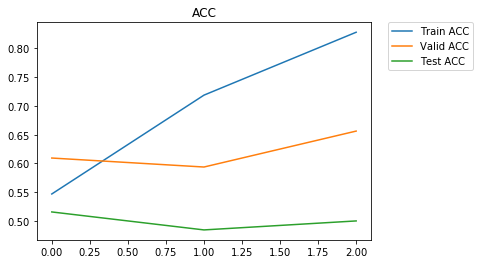

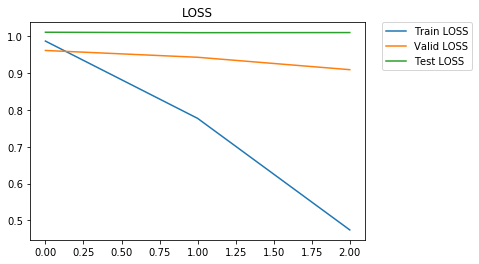

au_name AU06
----------------
epoch: 0
 phase: Train
    pose: posesall
          epoch_acc 0.984375
          epoch_loss 0.7222769558429718
 phase: Valid
    pose: pose1
          epoch_acc 0.65625
          epoch_loss 0.7396101653575897
 phase: Test
    pose: pose1
          epoch_acc 0.5
          epoch_loss 0.755348265171051
----------------
epoch: 1
 phase: Train
    pose: posesall
          epoch_acc 0.984375
          epoch_loss 0.6887982189655304
 phase: Valid
    pose: pose1
          epoch_acc 0.65625
          epoch_loss 0.7066889405250549
 phase: Test
    pose: pose1
          epoch_acc 0.5
          epoch_loss 0.7151011228561401
----------------
epoch: 2
 phase: Train
    pose: posesall
          epoch_acc 0.984375
          epoch_loss 0.6725296080112457
 phase: Valid
    pose: pose1
          epoch_acc 0.65625
          epoch_loss 0.705406904220581
 phase: Test
    pose: pose1
          epoch_acc 0.5
          epoch_loss 0.7168177962303162
best_epoch 2
---
Train ACC AVERA

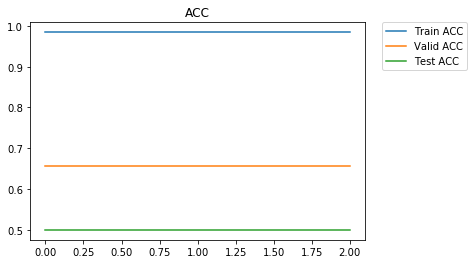

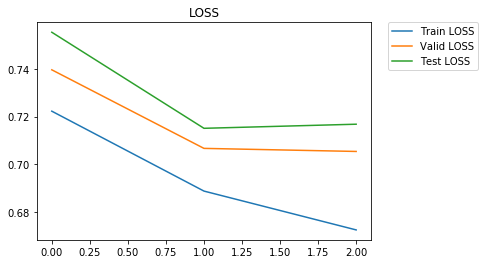

------------
AU06 Train
phase Train pose posesall
------------
AU06 Valid
phase Valid pose pose1
------------
AU06 Test
phase Test pose pose1
./pred_result/pred_result__AU06_procrustes-intensity-pose1_Valid_psedo.csv 1
AU06 Valid pose1 ICCV sampling: 64
./pred_result/pred_result__AU06_procrustes-intensity-pose1_Test_psedo.csv 1
AU06 Test pose1 ICCV sampling: 64
-0.544047 1.292983
Train posesall
file: ./BinaryData/AU_INT_CONV_AU06_Train_posesall.csv
Valid pose1
file: ./BinaryData/AU_INT_CONV_AU06_Valid_pose1.csv
Test pose1
file: ./BinaryData/AU_INT_CONV_AU06_Test_pose1.csv
epoch 0
------------
AU06 Train
phase Train pose posesall
F1 0.0
F1 (MEAN) 0.0
------------
AU06 Valid
phase Valid pose pose1
F1 0.3076923076923077
F1 (MEAN) 0.3076923076923077
------------
AU06 Test
phase Test pose pose1
F1 0.0
F1 (MEAN) 0.0
epoch 1
------------
AU06 Train
phase Train pose posesall
F1 0.5714285714285715
F1 (MEAN) 0.5714285714285715
------------
AU06 Valid
phase Valid pose pose1
F1 0.4819277108433735


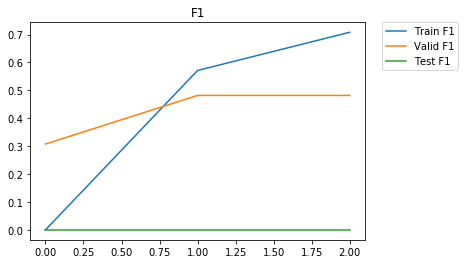

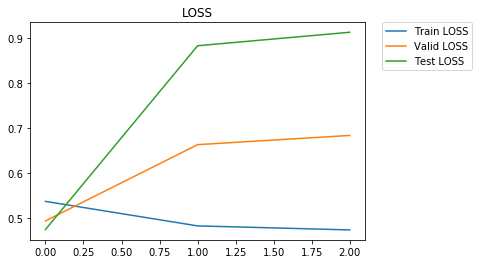

@@@@@@@@@@@@@@@@@@@@@@@@@@@@
trial: 1
au_name AU06
----------------
epoch: 0
 phase: Train
    pose: posesall
          epoch_acc 0.5
          epoch_loss 0.9278654158115387
 phase: Valid
    pose: pose1
          epoch_acc 0.515625
          epoch_loss 0.9897370338439941
 phase: Test
    pose: pose1
          epoch_acc 0.53125
          epoch_loss 1.0080240964889526
----------------
epoch: 1
 phase: Train
    pose: posesall
          epoch_acc 0.71875
          epoch_loss 0.7659308910369873
 phase: Valid
    pose: pose1
          epoch_acc 0.5625
          epoch_loss 0.950534999370575
 phase: Test
    pose: pose1
          epoch_acc 0.5625
          epoch_loss 0.9908098578453064
----------------
epoch: 2
 phase: Train
    pose: posesall
          epoch_acc 0.75
          epoch_loss 0.5755186676979065
 phase: Valid
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.9109931588172913
 phase: Test
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.9798690

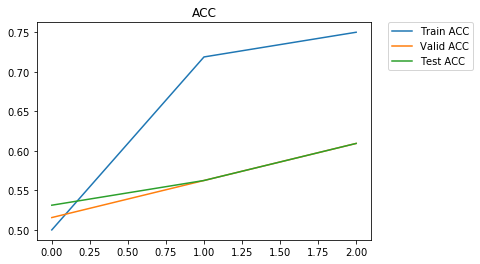

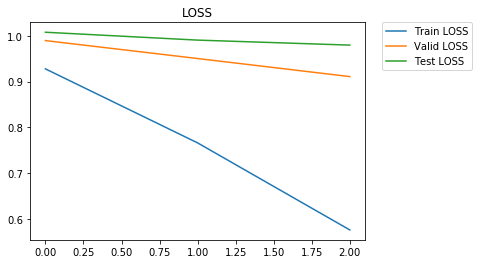

au_name AU06
----------------
epoch: 0
 phase: Train
    pose: posesall
          epoch_acc 1.0
          epoch_loss 0.7658281326293945
 phase: Valid
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.936553955078125
 phase: Test
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.971138596534729
----------------
epoch: 1
 phase: Train
    pose: posesall
          epoch_acc 1.0
          epoch_loss 0.7033357620239258
 phase: Valid
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.7498162090778351
 phase: Test
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.763253778219223
----------------
epoch: 2
 phase: Train
    pose: posesall
          epoch_acc 1.0
          epoch_loss 0.6845145225524902
 phase: Valid
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.7245613634586334
 phase: Test
    pose: pose1
          epoch_acc 0.609375
          epoch_loss 0.7371903657913208
best_epoch 2
---
Train ACC AVE

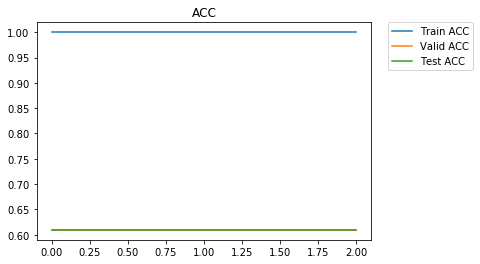

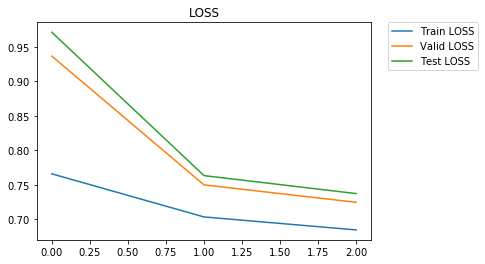

------------
AU06 Train
phase Train pose posesall
------------
AU06 Valid
phase Valid pose pose1
------------
AU06 Test
phase Test pose pose1
./pred_result/pred_result__AU06_procrustes-intensity-pose1_Valid_psedo.csv 1
AU06 Valid pose1 ICCV sampling: 64
./pred_result/pred_result__AU06_procrustes-intensity-pose1_Test_psedo.csv 1
AU06 Test pose1 ICCV sampling: 64
-1.042737 1.484277
Train posesall
file: ./BinaryData/AU_INT_CONV_AU06_Train_posesall.csv
Valid pose1
file: ./BinaryData/AU_INT_CONV_AU06_Valid_pose1.csv
Test pose1
file: ./BinaryData/AU_INT_CONV_AU06_Test_pose1.csv
epoch 0
------------
AU06 Train
phase Train pose posesall
F1 0.3272727272727273
F1 (MEAN) 0.3272727272727273
------------
AU06 Valid
phase Valid pose pose1
F1 0.368421052631579
F1 (MEAN) 0.368421052631579
------------
AU06 Test
phase Test pose pose1
F1 0.0
F1 (MEAN) 0.0
epoch 1
------------
AU06 Train
phase Train pose posesall
F1 0.5909090909090909
F1 (MEAN) 0.5909090909090909
------------
AU06 Valid
phase Valid pose 

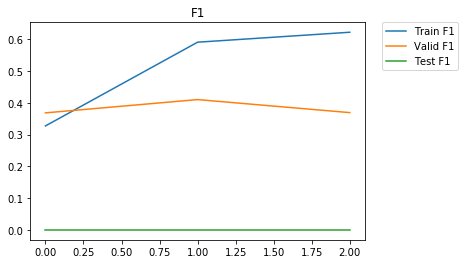

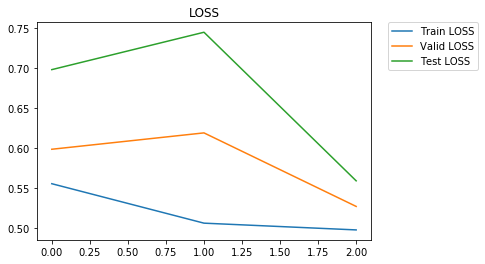

best_trial: 0
./pred_result/pred_result__AU06_procrustes-intensity-pose1_Valid_psedo.csv 1
AU06 ValidFull pose1 ICCV sampling: 210
./pred_result/pred_result__AU06_procrustes-intensity-pose1_Test_psedo.csv 1
AU06 TestFull pose1 ICCV sampling: 308
ValidFull pose1
file: ./BinaryData/AU_INT_CONV_AU06_ValidFull_pose1.csv
TestFull pose1
file: ./BinaryData/AU_INT_CONV_AU06_TestFull_pose1.csv
------------
AU06 ValidFull
phase ValidFull pose pose1
F1 0.34782608695652173
len 210
F1 (MEAN) 0.34782608695652173
------------
AU06 TestFull
phase TestFull pose pose1
F1 0.0
len 308
F1 (MEAN) 0.0


In [29]:
main()